In [22]:
import math
import numpy as np
import matplotlib.pyplot as plt

import skimage
from skimage import measure
from skimage import io
from skimage.filters import threshold_otsu
from skimage import feature
from skimage.color import rgb2gray
from skimage import filters
import skimage.morphology
import scipy as sp
from skimage import segmentation, filters
import os


In [102]:
white_image_array = np.full((19665840,), 255, dtype=np.uint8)

### BASELINE: TEST agasinst all white

In [115]:
baseline = []
for i in combined_list:
    left = io.imread(os.path.join(left_mask_folder, left_mask_images[i]))
    right = io.imread(os.path.join(right_mask_folder, right_mask_images[i]))
    mask = left + right 
    inverse_mask = np.invert(mask)


    white_image_array_bin = (white_image_array > 0).astype(int)
    mask_bin = (inverse_mask > 0).astype(int)
    score = dice_score(white_image_array_bin, mask_bin)
    baseline.append((score))
    
print(np.mean(baseline))

0.8452116505384026


In [126]:
def dice_score(imageA, imageB):
    # Flatten the images to 1D arrays
    imageA_flat = imageA.flatten()
    imageB_flat = imageB.flatten()

    # Calculate the intersection
    intersection = np.sum(imageA_flat * imageB_flat)
    
    # Calculate the Dice Score
    score = 2. * intersection / (np.sum(imageA_flat) + np.sum(imageB_flat))
    return score


def seg(image, left,right):

    mask = left + right 
    inverse_mask = np.invert(mask)


    # threshold to get the lungs and body
    threshold = threshold_otsu(image)
    binary = ~(image <= threshold)

    # threshold to just get the body 
    #threshold = 13.5
    #binary_2 = ~(image <= threshold)


    # actually watershed gets a better body
    markers = np.zeros_like(image)
    markers[image < 10] = 1
    markers[image >150] = 2
    elevation_map = filters.sobel(image)
    watershed_seg = segmentation.watershed(elevation_map, markers)
    binary3 = sp.ndimage.binary_fill_holes(watershed_seg-1)
    

    # remove the body from 'body +lungs', there is still some noise though
    main = binary +np.invert(binary3)


    # used morphology to remove noise 
    result_image = skimage.morphology.isotropic_closing(main, 30)

    # DICE TIME 
    result_image_bin = (result_image > 0).astype(int)
    mask_bin = (inverse_mask > 0).astype(int)
    score = dice_score(result_image_bin, mask_bin)

    #true positive
    total = np.shape(mask)
    size = np.shape(image)
   
    check = inverse_mask + result_image

    count0 = total[0]*total[1] - np.count_nonzero(mask)

    count1 = total[0]*total[1] - np.count_nonzero(check)
    true_positive = count1/count0

    return result_image, score, true_positive
    

In [124]:
def seg_threshold(image, left,right):

    mask = left + right 
    inverse_mask = np.invert(mask)

    # threshold to get the lungs and body
    threshold = threshold_otsu(image)
    binary = ~(image <= threshold)

    #threshold to just get the body 
    threshold = 13.5
    binary_2 = ~(image <= threshold)


    # remove the body from 'body +lungs', there is still some noise though
    main = binary +np.invert(binary_2)

    # used morphology to remove noise 
    result_image = skimage.morphology.isotropic_closing(main, 30)

    # DICE TIME 
    result_image_bin = (result_image > 0).astype(int)
    mask_bin = (inverse_mask > 0).astype(int)
    score = dice_score(result_image_bin, mask_bin)

    #true positive
    total = np.shape(mask)
    size = np.shape(image)
   
    check = mask + result_image

    count0 = total[0]*total[1] - np.count_nonzero(mask)

    count1 = total[0]*total[1] - np.count_nonzero(check)
    true_positive = count1/count0

    return result_image, score, true_positive

In [ ]:
#setting up a list to test on 
list1 = range(1, 20)
list_middle = range(75, 95)
list_late = range(110, 120)

# Combine the ranges into one list
combined_list = []

for i in list1:
    combined_list.append(i)
for i in list_middle:
    combined_list.append(i)
for i in list_late:
    combined_list.append(i)


In [121]:
# folders list
left_mask_folder = 'ManualMask/leftMask'
right_mask_folder = 'ManualMask/rightMask'
cxr_png_folder = 'CXR_png'


# list of files
left_mask_images = sorted(os.listdir(left_mask_folder))
right_mask_images = sorted(os.listdir(right_mask_folder))
cxr_png_images = sorted(os.listdir(cxr_png_folder))

dice_list_watershed=[]
dice_list_pos_watershed=[]

#for i in range len(cxr_png_images):
for i in combined_list:
    left = io.imread(os.path.join(left_mask_folder, left_mask_images[i]))
    right = io.imread(os.path.join(right_mask_folder, right_mask_images[i]))
    image = io.imread(os.path.join(cxr_png_folder, cxr_png_images[i]))
    result, dice, pos = seg(image, left, right )
    dice_list_watershed.append((dice))
    dice_list_pos_watershed.append((pos))

print(np.mean(dice_list_watershed))
print(np.mean(dice_list_pos_watershed))

0.9471304168995619
0.024802192362569135


In [118]:
dice_list=[]
dice_list_pos_watershed=[]

for i in combined_list:
    left = io.imread(os.path.join(left_mask_folder, left_mask_images[i]))
    right = io.imread(os.path.join(right_mask_folder, right_mask_images[i]))
    image = io.imread(os.path.join(cxr_png_folder, cxr_png_images[i]))
    result, dice,pos = seg_threshold(image, left, right )
    dice_list.append((dice))
    dice_list_pos_watershed.append((pos))

print(np.mean(dice_list_watershed))
print(np.mean(dice_list_pos_watershed))


0.9471304168995619
0.15302635696757316


# Experiments

In [4]:
left = io.imread("ManualMask/leftMask/MCUCXR_0001_0.png")
right = io.imread("ManualMask/rightMask/MCUCXR_0001_0.png")

In [3]:
mask = left + right 
inverse_mask = np.invert(mask)

In [3]:
image = io.imread("CXR_png/MCUCXR_0001_0.png")


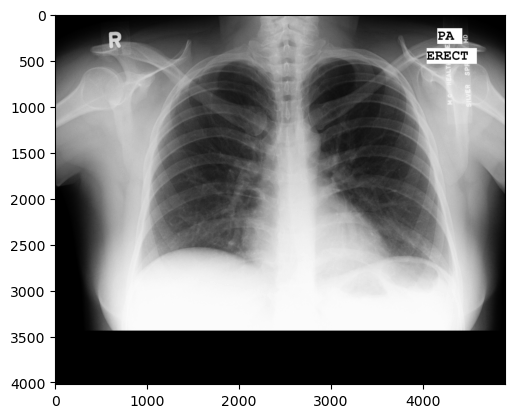

In [5]:
plt.imshow(image, cmap='gray')


In [6]:
threshold = threshold_otsu(image)
print(threshold) 
binary = ~(image <= threshold)

117


In [7]:
threshold = threshold_otsu(binary)
print(threshold) 
binary_2 = ~(binary <= threshold)

/usr/local/Caskroom/miniforge/base/envs/biomedia-environment/lib/python3.12/site-packages/skimage/exposure/exposure.py:306: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, bin_edges = np.histogram(image, bins=bins, range=hist_range)


0.001953125


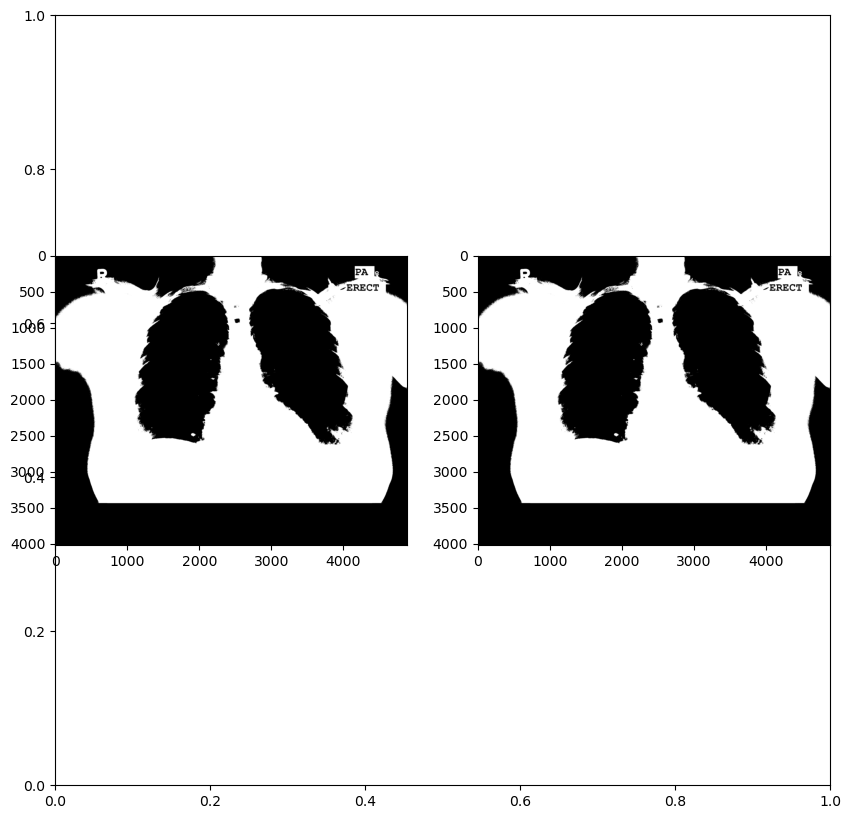

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(binary, cmap='gray')
plt.subplot(1,2, 2)
plt.imshow(binary_2, cmap='gray')
plt.show()

In [9]:

total = np.shape(inverse_mask)

size = np.shape(binary)

print(total)

print(size)

count = total[0]*total[1] - np.count_nonzero(inverse_mask)

print(count)

print(total[0]*total[1])

check = inverse_mask + binary

count1 = total[0]*total[1] - np.count_nonzero(check)


output = count1/count


(4020, 4892)
(4020, 4892)
4753493
19665840


In [10]:
print(output)

0.8176040229784708


what percentage of true space we have founds, but doesnt tell us us what we have identifed as lung that isnt lung 

In [11]:
threshold = 13.5
print(threshold) 
binary_2 = ~(image <= threshold)



13.5


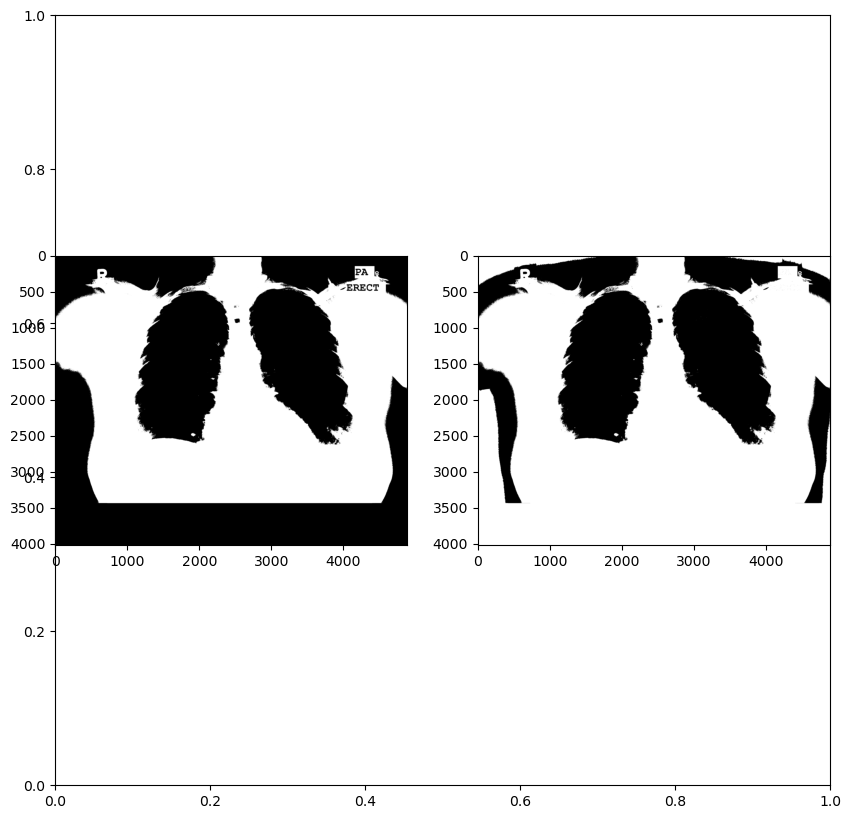

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(binary, cmap='gray')
plt.subplot(1,2, 2)
plt.imshow(binary + np.invert(binary_2), cmap='gray')
plt.show()

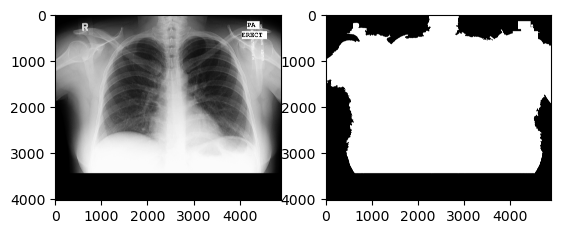

In [13]:
import scipy as sp

from skimage import segmentation, filters

markers = np.zeros_like(image)

markers[image < 10] = 1

markers[image >150] = 2


elevation_map = filters.sobel(image)

watershed_seg = segmentation.watershed(elevation_map, markers)

binary3 = sp.ndimage.binary_fill_holes(watershed_seg-1)


plt.subplot(1,2,1)

plt.imshow(image, cmap='gray')

plt.subplot(1,2, 2)

plt.imshow(binary3, cmap='gray')

plt.show()

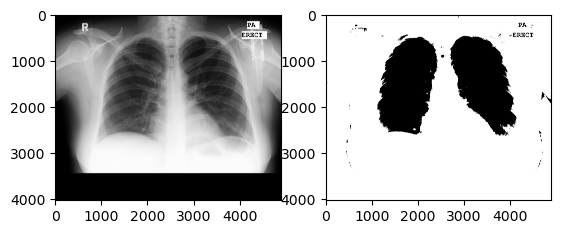

In [25]:
plt.subplot(1,2,1)

plt.imshow(image, cmap='gray')

plt.subplot(1,2, 2)

plt.imshow(binary +np.invert(binary3), cmap='gray')

plt.show()

In [15]:
test = binary +np.invert(binary3)

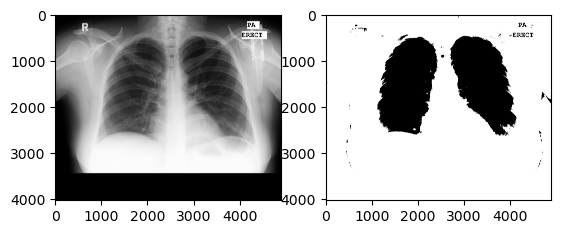

In [16]:
plt.subplot(1,2,1)

plt.imshow(image, cmap='gray')

plt.subplot(1,2, 2)

plt.imshow(test, cmap='gray')

plt.show()

In [36]:
result = skimage.morphology.isotropic_closing(test, 30)

In [34]:
import skimage.morphology

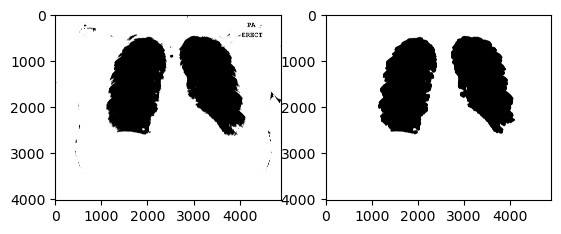

In [37]:
plt.subplot(1,2,1)

plt.imshow(test, cmap='gray')

plt.subplot(1,2, 2)

plt.imshow(result, cmap='gray')

plt.show()